In [3]:
pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=2153fce40c97af7bd4e412f633a6cafe51c4ca233883f92a54580662197e0dd9
  Stored in directory: /root/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import os
import yfinance as yf
import ta

### Data Loading and Preprocessing

In [21]:
# Load the dataset
file_path = 'nasdaq.csv'
nasdaq_data = pd.read_csv(file_path)

#Remove unwanted cols
del nasdaq_data['Unnamed: 0']

nasdaq_data.head(15)

,Date,Open,High,Low,Close,Volume,EMA_50,EMA_200,RSI,MACD,MACD_Signal,MACD_Hist
0,1990-01-02 05:00:00+00:00,452.899994,459.299988,452.700012,459.299988,110720000,453.490768,444.839773,62.885333,-1.049759,-2.890670,1.840911
1,1990-01-03 05:00:00+00:00,461.100006,461.600006,460.000000,460.899994,152660000,453.781326,444.999576,64.551665,-0.049565,-2.322449,2.272884
2,1990-01-04 05:00:00+00:00,460.399994,460.799988,456.899994,459.399994,147950000,454.001666,445.142864,61.752523,0.614970,-1.734965,2.349935
3,1990-01-05 05:00:00+00:00,457.899994,459.399994,457.799988,458.200012,137230000,454.166307,445.272785,59.528642,1.032884,-1.181395,2.214279
4,1990-01-08 05:00:00+00:00,457.100006,458.700012,456.500000,458.700012,115500000,454.344100,445.406390,60.172252,1.388424,-0.667432,2.055856
5,1990-01-09 05:00:00+00:00,459.200012,459.600006,456.600006,456.799988,131130000,454.440409,445.519759,56.495515,1.499590,-0.234027,1.733617
6,1990-01-10 05:00:00+00:00,455.100006,456.299988,450.600006,450.700012,143890000,454.293727,445.571304,46.641888,1.082989,0.029376,1.053613
7,1990-01-11 05:00:00+00:00,451.700012,452.500000,448.799988,448.899994,133000000,454.082208,445.604425,44.192465,0.600659,0.143633,0.457026
8,1990-01-12 05:00:00+00:00,442.700012,446.600006,439.299988,439.700012,143500000,453.518200,445.545674,34.282804,-0.517982,0.011310,-0.529291
9,1990-01-15 05:00:00+00:00,438.200012,439.399994,436.399994,436.600006,108060000,452.854741,445.456663,31.703085,-1.635800,-0.318112,-1.317688


#### Feature Engineering

In [22]:
# Create a target variable for classification (1 day ahead)
# Here we have taken a 2% change for the target variable (>2: Up, <2: down, else neutral)
def classify_target(row):
    change = (row['Close_1_days_ahead'] - row['Close']) / row['Close']
    if change > 0.02:
        return 1  # Up
    elif change < -0.02:
        return 0  # Down
    else:
        return 2  # Neutral

nasdaq_data['Close_1_days_ahead'] = nasdaq_data['Close'].shift(-1)
nasdaq_data['Target'] = nasdaq_data.apply(classify_target, axis=1)
nasdaq_data = nasdaq_data[:-1]  # Remove the last 1 row with NaN target

nasdaq_data.head(15)


,Date,Open,High,Low,Close,Volume,EMA_50,EMA_200,RSI,MACD,MACD_Signal,MACD_Hist,Close_1_days_ahead,Target
0,1990-01-02 05:00:00+00:00,452.899994,459.299988,452.700012,459.299988,110720000,453.490768,444.839773,62.885333,-1.049759,-2.890670,1.840911,460.899994,2
1,1990-01-03 05:00:00+00:00,461.100006,461.600006,460.000000,460.899994,152660000,453.781326,444.999576,64.551665,-0.049565,-2.322449,2.272884,459.399994,2
2,1990-01-04 05:00:00+00:00,460.399994,460.799988,456.899994,459.399994,147950000,454.001666,445.142864,61.752523,0.614970,-1.734965,2.349935,458.200012,2
3,1990-01-05 05:00:00+00:00,457.899994,459.399994,457.799988,458.200012,137230000,454.166307,445.272785,59.528642,1.032884,-1.181395,2.214279,458.700012,2
4,1990-01-08 05:00:00+00:00,457.100006,458.700012,456.500000,458.700012,115500000,454.344100,445.406390,60.172252,1.388424,-0.667432,2.055856,456.799988,2
5,1990-01-09 05:00:00+00:00,459.200012,459.600006,456.600006,456.799988,131130000,454.440409,445.519759,56.495515,1.499590,-0.234027,1.733617,450.700012,2
6,1990-01-10 05:00:00+00:00,455.100006,456.299988,450.600006,450.700012,143890000,454.293727,445.571304,46.641888,1.082989,0.029376,1.053613,448.899994,2
7,1990-01-11 05:00:00+00:00,451.700012,452.500000,448.799988,448.899994,133000000,454.082208,445.604425,44.192465,0.600659,0.143633,0.457026,439.700012,0
8,1990-01-12 05:00:00+00:00,442.700012,446.600006,439.299988,439.700012,143500000,453.518200,445.545674,34.282804,-0.517982,0.011310,-0.529291,436.600006,2
9,1990-01-15 05:00:00+00:00,438.200012,439.399994,436.399994,436.600006,108060000,452.854741,445.456663,31.703085,-1.635800,-0.318112,-1.317688,440.200012,2


In [23]:
nasdaq_data.tail(3)

,Date,Open,High,Low,Close,Volume,EMA_50,EMA_200,RSI,MACD,MACD_Signal,MACD_Hist,Close_1_days_ahead,Target
8694,2024-07-09 04:00:00+00:00,18465.019531,18511.890625,18381.599609,18429.289062,4839140000,17238.359870,15702.710764,76.984401,357.604954,323.456373,34.148581,18647.449219,2
8695,2024-07-10 04:00:00+00:00,18512.089844,18655.189453,18467.580078,18647.449219,5228240000,17293.618276,15732.011644,80.032922,379.729000,334.710898,45.018102,18283.410156,2
8696,2024-07-11 04:00:00+00:00,18659.250000,18671.070312,18238.779297,18283.410156,6366620000,17332.433644,15757.398694,64.645599,363.695104,340.507739,23.187365,18398.449219,2


In [24]:
nasdaq_data['Target'].unique()

array([2, 0, 1])

In [25]:
nasdaq_data['Target'].value_counts()

,count
Target,
2,7580
0,602
1,515


In [63]:
# Add moving averages
nasdaq_data['MA10'] = nasdaq_data['Close'].rolling(window=10).mean()
nasdaq_data['MA50'] = nasdaq_data['Close'].rolling(window=10).mean()
nasdaq_data['MA200'] = nasdaq_data['Close'].rolling(window=10).mean()
#Measures volatility and can indicate potential overbought or oversold conditions
#Compares a particular closing price of a security to a range of its prices over a certain period.
nasdaq_data['BB_upper'], nasdaq_data['BB_middle'], nasdaq_data['BB_lower'] = ta.volatility.BollingerBands(nasdaq_data['Close']).bollinger_hband(), ta.volatility.BollingerBands(nasdaq_data['Close']).bollinger_mavg(), ta.volatility.BollingerBands(nasdaq_data['Close']).bollinger_lband()
nasdaq_data['Stochastic'] = ta.momentum.StochasticOscillator(nasdaq_data['High'], nasdaq_data['Low'], nasdaq_data['Close']).stoch()

nasdaq_data.dropna(inplace=True)  # Drop rows with NaN values

In [64]:
# Select features based on correlation
# features = ['RSI', 'MACD_Signal', 'MACD', 'Volume', 'MA10', 'MA50', 'MA200', 'EMA_50', 'EMA_200']
features = ['RSI', 'MACD_Signal', 'MACD', 'Volume', 'MA10', 'MA50', 'MA200', 'BB_upper', 'BB_middle', 'BB_lower', 'Stochastic']

# Features and target
X = nasdaq_data[features]
y = nasdaq_data['Target']

In [65]:
# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [ ]:
# Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
# Oversample the minority classes (0 and 1)
# ros = RandomOverSampler(random_state=42)
# X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

In [66]:
# Define classifiers to compare for best model selection
classifiers = {
    'GradientBoosting': GradientBoostingClassifier(random_state=42),
    'RandomForest': RandomForestClassifier(random_state=42, class_weight='balanced'),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'LogisticRegression': LogisticRegression(random_state=42, max_iter=10000, class_weight='balanced'),
    'SVM': SVC(random_state=42, class_weight='balanced'),
    'XGBoost': xgb.XGBClassifier(random_state=42, scale_pos_weight=len(y)/sum(y == 1))
}

In [67]:
# Use TimeSeriesSplit for time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

In [68]:
# Compare classifiers using time series cross-validation
best_classifier = None
best_score = 0
results = {}

for name, clf in classifiers.items():
    scores = []
    for train_index, test_index in tscv.split(X_scaled):
        # Convert train and test indices to lists
        train_index = list(train_index)
        test_index = list(test_index)

        X_train, X_test = X_scaled[train_index], X_scaled[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Oversample the minority classes (0 and 1) in the training set
        # ros = RandomOverSampler(random_state=42)
        smote = SMOTE(random_state=42)
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

        clf.fit(X_train_resampled, y_train_resampled)
        y_pred = clf.predict(X_test)
        scores.append(accuracy_score(y_test, y_pred))

    avg_score = np.mean(scores)
    results[name] = avg_score
    if avg_score > best_score:
        best_score = avg_score
        best_classifier = clf

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:15:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:15:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:15:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:15:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:15:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weigh

In [ ]:
# # Compare classifiers
# best_classifier = None
# best_score = 0
# results = {}

# for name, clf in classifiers.items():
#     scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')
#     avg_score = scores.mean()
#     results[name] = avg_score
#     if avg_score > best_score:
#         best_score = avg_score
#         best_classifier = clf


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:33:37] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:33:38] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:33:38] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:33:39] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:33:39] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weigh

In [70]:
# Print results
print("\nModels & Accuracies:\n")
for name, score in results.items():
    print(f"{name}: {score:.4f}")

print(f"\nBest Classifier: {best_classifier.__class__.__name__} with score: {best_score:.4f}")



Models & Accuracies:

GradientBoosting: 0.4661
RandomForest: 0.5288
AdaBoost: 0.4886
LogisticRegression: 0.4337
SVM: 0.5044
XGBoost: 0.5931

Best Classifier: XGBClassifier with score: 0.5931


In [22]:
# # Train the best classifier on the full training set
# best_classifier.fit(X_train_resampled, y_train_resampled)

# # Make predictions
# y_pred = best_classifier.predict(X_test)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:06:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


In [71]:
# Train the best classifier on the full training set
train_index, test_index = list(tscv.split(X_scaled))[-1]
X_train, X_test = X_scaled[train_index], X_scaled[test_index]
y_train, y_test = y.iloc[train_index], y.iloc[test_index]

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

best_classifier.fit(X_train_resampled, y_train_resampled)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:15:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [73]:
# Predict the model on the last split
y_pred = best_classifier.predict(X_test)

In [74]:
# Evaluate the model
classification_report_result = classification_report(y_test, y_pred)
confusion_matrix_result = confusion_matrix(y_test, y_pred)
accuracy_result = accuracy_score(y_test, y_pred)


In [75]:
# Print the evaluation metrics
print("\nClassification Report:\n", classification_report_result)
print("Confusion Matrix:\n", confusion_matrix_result)
print("Accuracy Score:", accuracy_result)


Classification Report:
               precision    recall  f1-score   support

           0       0.11      0.10      0.10       114
           1       0.29      0.04      0.07       104
           2       0.86      0.93      0.89      1226

    accuracy                           0.80      1444
   macro avg       0.42      0.36      0.36      1444
weighted avg       0.76      0.80      0.77      1444

Confusion Matrix:
 [[  11    2  101]
 [  14    4   86]
 [  74    8 1144]]
Accuracy Score: 0.8026315789473685


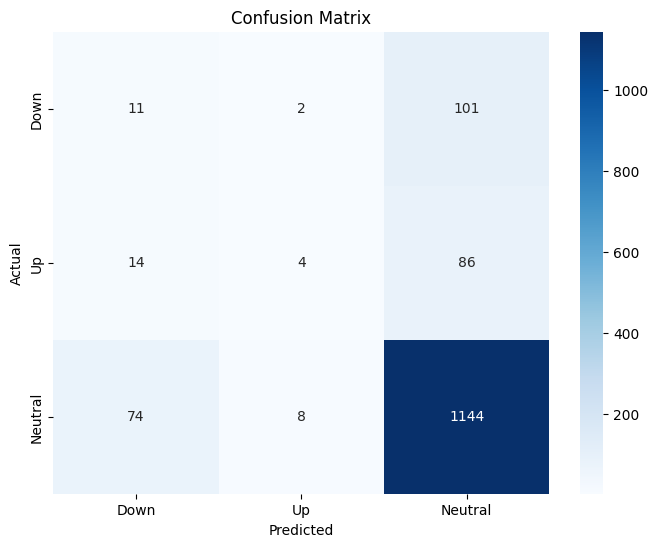

In [76]:
# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=['Down', 'Up', 'Neutral'], yticklabels=['Down', 'Up', 'Neutral'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [77]:
# Make predictions for the entire dataset
nasdaq_data['Predicted'] = best_classifier.predict(scaler.transform(nasdaq_data[features]))

In [78]:
nasdaq_data.head(15)

,Date,Open,High,Low,Close,Volume,EMA_50,EMA_200,RSI,MACD,...,Close_1_days_ahead,Target,MA10,MA50,MA200,Predicted,BB_upper,BB_middle,BB_lower,Stochastic
28,1990-02-09 05:00:00+00:00,428.700012,429.100006,427.500000,428.799988,125330000,438.468928,442.173888,46.445177,-5.305580,...,426.399994,2,421.619998,421.619998,421.619998,2,443.809278,427.230000,410.650722,78.991586
29,1990-02-12 05:00:00+00:00,428.799988,428.799988,425.799988,426.399994,113030000,437.995637,442.016934,43.665142,-4.864490,...,425.799988,2,422.449997,422.449997,422.449997,2,442.732821,426.720000,410.707179,81.188040
30,1990-02-13 05:00:00+00:00,425.299988,427.000000,423.899994,425.799988,127230000,437.517376,441.855572,42.972623,-4.511335,...,426.600006,2,423.959995,423.959995,423.959995,2,440.770373,425.999998,411.229624,78.217714
31,1990-02-14 05:00:00+00:00,426.799988,427.200012,425.500000,426.600006,139540000,437.089244,441.703775,44.242407,-4.119416,...,429.600006,2,425.039996,425.039996,425.039996,2,438.978584,425.394998,411.811413,82.178198
32,1990-02-15 05:00:00+00:00,426.299988,429.700012,425.899994,429.600006,152380000,436.795548,441.583339,48.842452,-3.526096,...,429.000000,2,426.219998,426.219998,426.219998,2,437.574572,424.999998,412.425425,97.029675
33,1990-02-16 05:00:00+00:00,430.000000,430.899994,428.899994,429.000000,120220000,436.489841,441.458132,47.989695,-3.068924,...,423.799988,2,426.899997,426.899997,426.899997,2,434.861663,424.404999,413.948334,90.909117
34,1990-02-20 05:00:00+00:00,425.399994,427.899994,421.799988,423.799988,108280000,435.992199,441.282429,41.265395,-3.090583,...,421.500000,2,426.809995,426.809995,426.809995,2,433.875420,423.999998,414.124577,63.775490
35,1990-02-21 05:00:00+00:00,418.899994,421.899994,418.399994,421.500000,120100000,435.423878,441.085589,38.683544,-3.255807,...,422.799988,2,426.559995,426.559995,426.559995,2,433.030750,423.554999,414.079248,36.054384
36,1990-02-22 05:00:00+00:00,422.600006,425.100006,422.200012,422.799988,134870000,434.928823,440.903643,40.933055,-3.244450,...,419.500000,2,426.159995,426.159995,426.159995,2,432.838653,423.409998,413.981342,39.097643
37,1990-02-23 05:00:00+00:00,421.100006,421.500000,418.100006,419.500000,117220000,434.323771,440.690671,37.201973,-3.461826,...,421.000000,2,425.379996,425.379996,425.379996,2,432.663940,423.124997,413.586054,10.937463


In [79]:
# Predict the market trend for the next day
next_days_predictions = []
next_days_prices = []
current_features = nasdaq_data[features].iloc[-1]
current_price = nasdaq_data['Close'].iloc[-1]

In [80]:
# Predict for 1 day
prediction = best_classifier.predict(scaler.transform([current_features]))[0]

# Update the price based on the prediction
if prediction == 1:
    next_price = current_price * 1.02  # Assuming a 2% increase
elif prediction == 0:
    next_price = current_price * 0.98  # Assuming a 2% decrease
else:
    next_price = current_price  # No change for neutral

next_days_prices.append(next_price)
current_price = next_price

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [81]:
# Print the predictions for next day
print("Predictions for the next day: ", ["Up" if prediction == 1 else "Down" if prediction == 0 else "Neutral"])
print("Predicted price for the next day: ", next_days_prices)

Predictions for the next day:  ['Neutral']
Predicted price for the next day:  [18283.41015625]


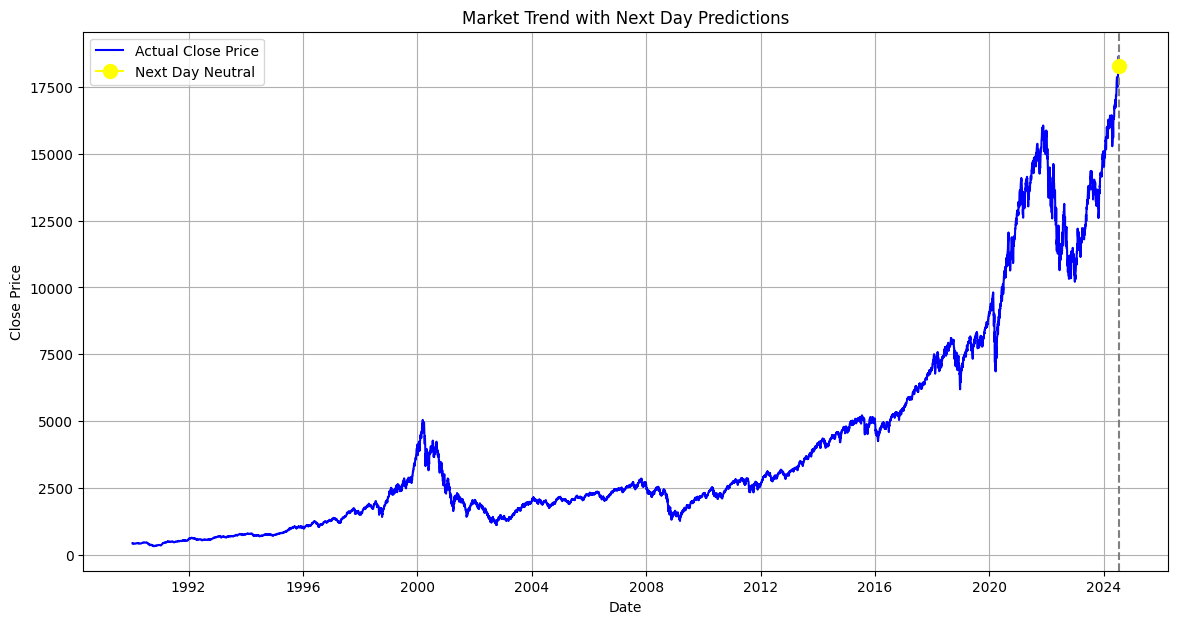

In [43]:
# Plot the actual market trend and the predicted trend for the next days

nasdaq_data['Date'] = pd.to_datetime(nasdaq_data['Date'])
plt.figure(figsize=(14, 7))
plt.plot(nasdaq_data['Date'], nasdaq_data['Close'], label='Actual Close Price', color='blue')
plt.axvline(x=nasdaq_data['Date'].iloc[-1], color='gray', linestyle='--')

last_date = nasdaq_data['Date'].iloc[-1]
date = pd.to_datetime(last_date) + pd.DateOffset(days=1)  # Compute the next date
close_price = nasdaq_data['Close'].iloc[-1]
color = 'green' if prediction == 1 else 'red' if prediction == 0 else 'yellow'
plt.plot(date, close_price, marker='o', color=color, markersize=10,
         label=f'Next Day {"Up" if prediction == 1 else "Down" if prediction == 0 else "Neutral"}')

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Market Trend with Next Day Predictions')
plt.legend()
plt.grid(True)
plt.show()


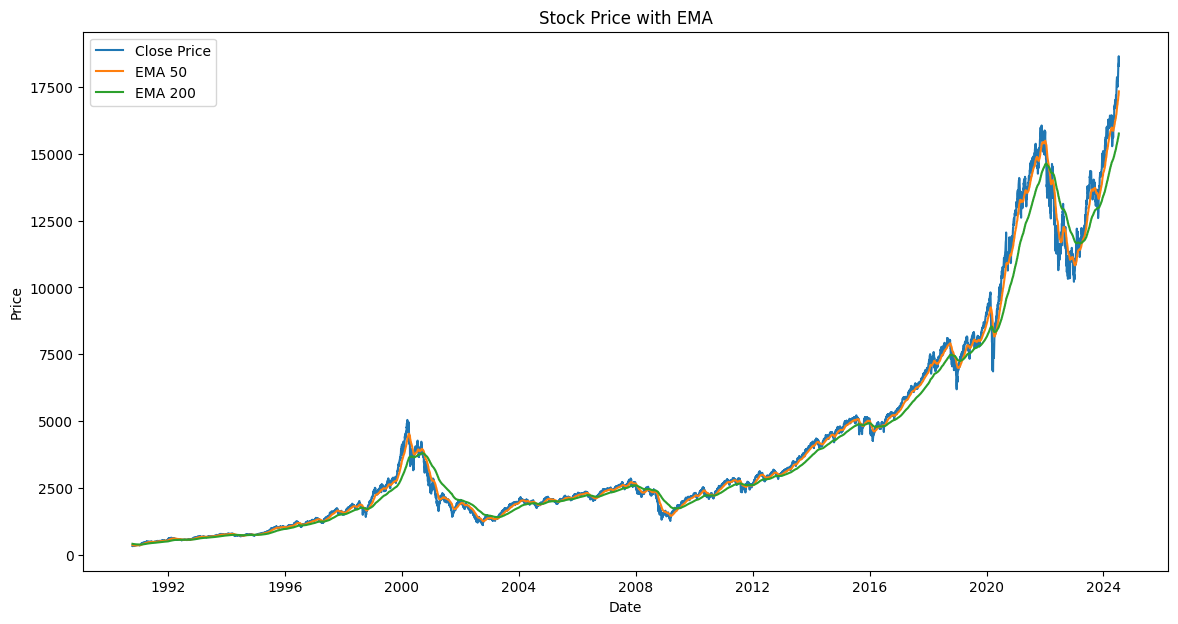

In [ ]:
# Time series plot for EMA 50 and 200 with closing price
plt.figure(figsize=(14, 7))
plt.plot(nasdaq_data['Date'], nasdaq_data['Close'], label='Close Price')
plt.plot(nasdaq_data['Date'], nasdaq_data['EMA_50'], label='EMA 50')
plt.plot(nasdaq_data['Date'], nasdaq_data['EMA_200'], label='EMA 200')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Stock Price with EMA')
plt.legend()
plt.show()

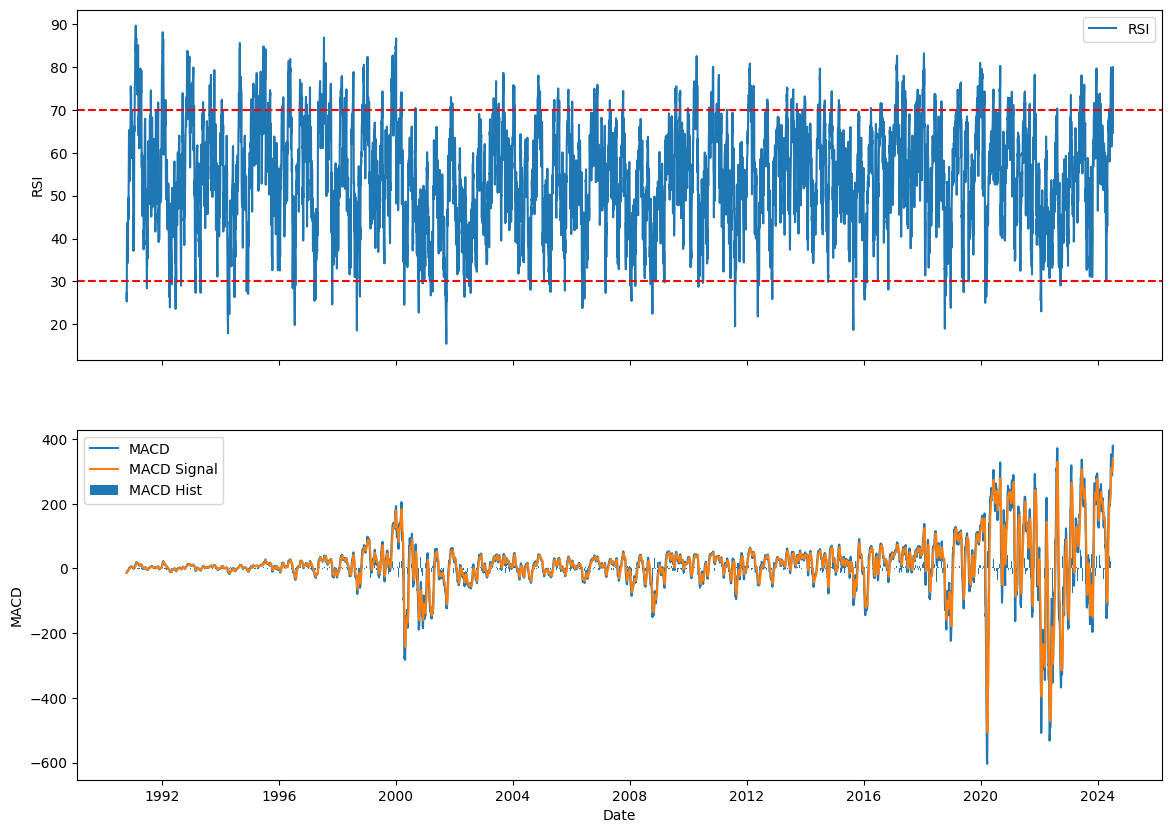

In [ ]:
# RSI and MACD plot
fig, ax = plt.subplots(2, 1, figsize=(14, 10), sharex=True)
ax[0].plot(nasdaq_data['Date'], nasdaq_data['RSI'], label='RSI')
ax[0].axhline(70, color='r', linestyle='--')
ax[0].axhline(30, color='r', linestyle='--')
ax[0].set_ylabel('RSI')
ax[0].legend()

ax[1].plot(nasdaq_data['Date'], nasdaq_data['MACD'], label='MACD')
ax[1].plot(nasdaq_data['Date'], nasdaq_data['MACD_Signal'], label='MACD Signal')
ax[1].bar(nasdaq_data['Date'], nasdaq_data['MACD_Hist'], label='MACD Hist')
ax[1].set_xlabel('Date')
ax[1].set_ylabel('MACD')
ax[1].legend()

plt.show()

1) The first plot is a graph of the Relative Strength Index (RSI) for NASDAQ from 1990 to 2024. The RSI is a momentum oscillator that measures the speed and change of price movements. It is used by traders to identify overbought or oversold conditions in a market. When the RSI is above 70 (the upper red dashed line), it suggests that the market may be overbought, and a downward correction in price could be forthcoming. Conversely, when the RSI is below 30 (the lower red dashed line), it indicates that the market may be oversold, and an upward correction could be expected.

2) The second plot shows the Moving Average Convergence Divergence (MACD) for the same period. The MACD is a trend-following momentum indicator that shows the relationship between two moving averages of a security’s price. The MACD line (blue) is the difference between a short-term and a long-term moving average. The MACD Signal line (orange) is a moving average of the MACD line. When the MACD line crosses above the Signal line, it generates a bullish signal, indicating that it may be an optimal time to buy. Conversely, when the MACD line crosses below the Signal line, it generates a bearish signal, suggesting that it might be an optimal time to sell. The MACD Histogram (vertical bars) represents the difference between the MACD line and the Signal line, which can provide additional insights into the bullish or bearish momentum in the market.

In [56]:
print(f'Y Test:\n{y_test}')

Y Test:
7251    2
7252    1
7253    2
7254    1
7255    2
       ..
8692    2
8693    2
8694    2
8695    2
8696    2
Name: Target, Length: 1446, dtype: int64


In [57]:
print(f'Y Pred:\n{y_pred}')

Y Pred:
[1 1 1 ... 2 2 2]


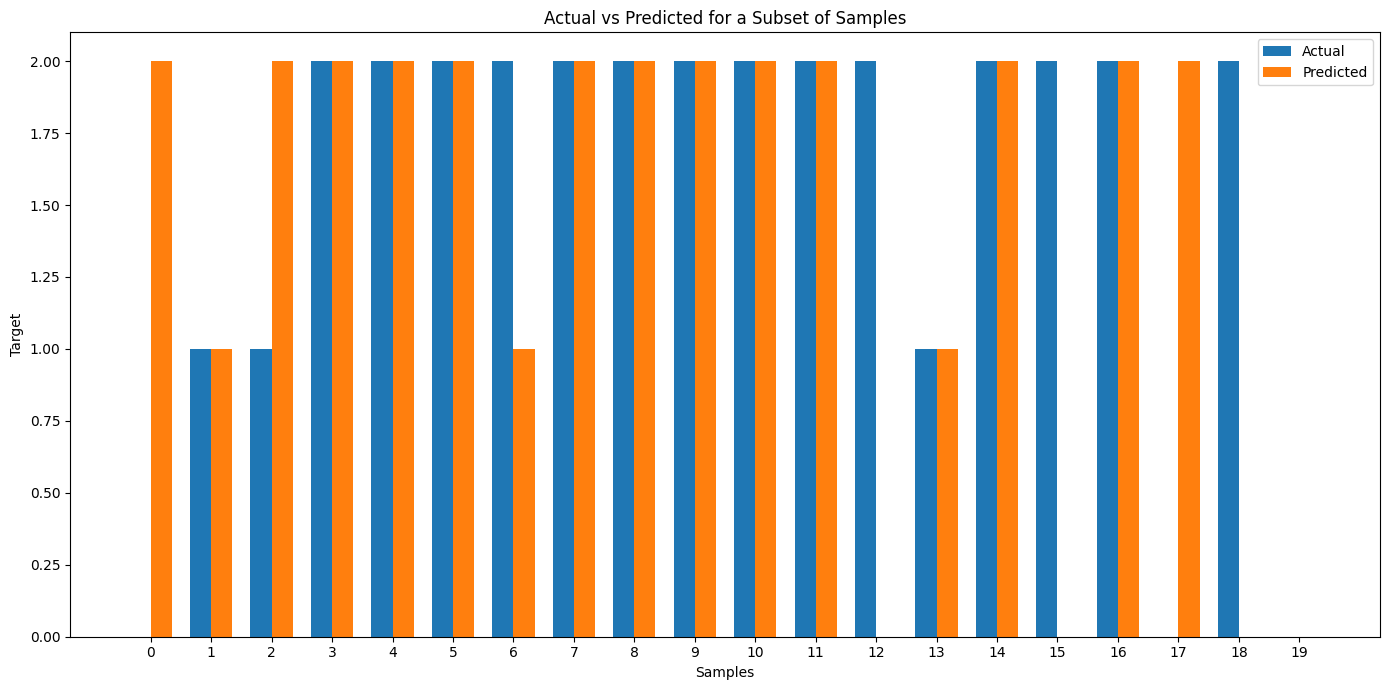

In [96]:
import numpy as np

# Select a subset of the data for clearer visualization
subset_size = 20
subset_indices = np.random.choice(len(y_test), subset_size, replace=False)
subset_actual = y_test.iloc[subset_indices]
subset_predicted = y_pred[subset_indices]

x = np.arange(subset_size)  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(14, 7))
rects1 = ax.bar(x - width/2, subset_actual, width, label='Actual')
rects2 = ax.bar(x + width/2, subset_predicted, width, label='Predicted')

ax.set_xlabel('Samples')
ax.set_ylabel('Target')
ax.set_title('Actual vs Predicted for a Subset of Samples')
ax.set_xticks(x)
ax.legend()

fig.tight_layout()
plt.show()


In [90]:
from datetime import datetime
import os
import pandas as pd
import yfinance as yf

# Load or fetch NASDAQ data
if os.path.exists("nasdaq_new.csv"):
    nasdaq_new = pd.read_csv("nasdaq_new.csv")
else:
    nasdaq_new = yf.Ticker("^IXIC")
    nasdaq_new = nasdaq_new.history(period="max")
    nasdaq_new.to_csv("nasdaq_new.csv")


In [91]:
nasdaq_new.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1971-02-05 00:00:00-05:00,100.000000,100.000000,100.000000,100.000000,0,0.0,0.0
1971-02-08 00:00:00-05:00,100.839996,100.839996,100.839996,100.839996,0,0.0,0.0
1971-02-09 00:00:00-05:00,100.760002,100.760002,100.760002,100.760002,0,0.0,0.0
1971-02-10 00:00:00-05:00,100.690002,100.690002,100.690002,100.690002,0,0.0,0.0
1971-02-11 00:00:00-05:00,101.449997,101.449997,101.449997,101.449997,0,0.0,0.0


In [92]:
# Technical indicators
# Calculate technical indicators
print("Calculating technical indicators...")
nasdaq_new['EMA_50'] = ta.trend.ema_indicator(nasdaq_new['Close'], window=50)
nasdaq_new['EMA_200'] = ta.trend.ema_indicator(nasdaq_new['Close'], window=200)
nasdaq_new['RSI'] = ta.momentum.rsi(nasdaq_new['Close'])
macd = ta.trend.MACD(nasdaq_new['Close'])
nasdaq_new['MACD'] = macd.macd()
nasdaq_new['MACD_Signal'] = macd.macd_signal()
nasdaq_new['MACD_Hist'] = macd.macd_diff()

# Add moving averages
nasdaq_new['MA10'] = nasdaq_new['Close'].rolling(window=10).mean()
nasdaq_new['MA50'] = nasdaq_new['Close'].rolling(window=10).mean()
nasdaq_new['MA200'] = nasdaq_new['Close'].rolling(window=10).mean()

# Measures volatility and can indicate potential overbought or oversold conditions
# Compares a particular closing price of a security to a range of its prices over a certain period.
nasdaq_new['BB_upper'], nasdaq_new['BB_middle'], nasdaq_new['BB_lower'] = ta.volatility.BollingerBands(nasdaq_new['Close']).bollinger_hband(), ta.volatility.BollingerBands(nasdaq_new['Close']).bollinger_mavg(), ta.volatility.BollingerBands(nasdaq_new['Close']).bollinger_lband()

nasdaq_new['Stochastic'] = ta.momentum.StochasticOscillator(nasdaq_new['High'], nasdaq_new['Low'], nasdaq_new['Close']).stoch()

nasdaq_new.dropna(inplace=True)  # Drop rows with NaN values


Calculating technical indicators...


In [94]:
# Removing the unwanted columns
del nasdaq_new['Dividends']
del nasdaq_new['Stock Splits']

In [95]:
nasdaq_new.tail(3)

,Open,High,Low,Close,Volume,EMA_50,EMA_200,RSI,MACD,MACD_Signal,MACD_Hist,MA10,MA50,MA200,BB_upper,BB_middle,BB_lower,Stochastic
Date,,,,,,,,,,,,,,,,,,
2024-07-29 00:00:00-04:00,17444.390625,17535.320312,17299.830078,17370.199219,4897230000,17509.808776,15992.772783,41.187041,-56.942725,94.940747,-151.883472,17736.155078,17736.155078,17736.155078,18877.366723,18022.279004,17167.191285,20.538535
2024-07-30 00:00:00-04:00,17424.099609,17468.560547,17015.380859,17147.419922,5564310000,17495.597448,16004.261809,37.406621,-97.479489,56.456700,-153.936189,17599.963086,17599.963086,17599.963086,18920.995412,17985.684961,17050.374510,7.974869
2024-07-31 00:00:00-04:00,17499.199219,17693.984375,17438.601562,17599.400391,5515835000,17499.668152,16020.133835,47.862472,-92.072763,26.750807,-118.823570,17560.211133,17560.211133,17560.211133,18914.182366,17964.216992,17014.251618,35.914282


In [96]:
# Filter the data starting from 2024-07-11
nasdaq_new.reset_index(inplace=True)  # Reset the index to access 'Date' column
nasdaq_new['Date'] = pd.to_datetime(nasdaq_new['Date'], utc=True)

nasdaq_new = nasdaq_new[nasdaq_new['Date'] > '2024-07-11']

nasdaq_new.head()


,Date,Open,High,Low,Close,Volume,EMA_50,EMA_200,RSI,MACD,MACD_Signal,MACD_Hist,MA10,MA50,MA200,BB_upper,BB_middle,BB_lower,Stochastic
13273,2024-07-11 04:00:00+00:00,18659.250000,18671.070312,18238.779297,18283.410156,6366620000,17332.433644,15757.398694,64.645599,363.695104,340.507739,23.187365,18180.428906,18180.428906,18180.428906,18578.418751,17945.950000,17313.481249,67.065129
13274,2024-07-12 04:00:00+00:00,18303.640625,18556.730469,18293.599609,18398.449219,5845930000,17374.238176,15783.677803,66.816775,356.165167,343.639225,12.525943,18234.405859,18234.405859,18234.405859,18627.279127,17985.450488,17343.621850,76.838629
13275,2024-07-15 04:00:00+00:00,18485.910156,18641.529297,18397.830078,18472.570312,5450350000,17417.310025,15810.432953,68.172990,352.119576,345.335295,6.784281,18308.402930,18308.402930,18308.402930,18683.507890,18025.700977,17367.894063,82.346760
13276,2024-07-16 04:00:00+00:00,18534.269531,18576.830078,18386.070312,18509.339844,5812930000,17460.134724,15837.287748,68.853064,347.870376,345.842311,2.028065,18371.406836,18371.406836,18371.406836,18737.596610,18066.723926,17395.851242,84.041274
13277,2024-07-17 04:00:00+00:00,18188.189453,18223.240234,17972.869141,17996.919922,6007280000,17481.185123,15858.776625,52.134230,299.700093,336.613868,-36.913775,18368.222852,18368.222852,18368.222852,18738.590189,18073.718945,17408.847702,33.478326


In [97]:
#save the latest file
nasdaq_new.to_csv("nasdaq_new.csv")

In [98]:
#Creating a target variable/column for predictions
# nasdaq_new['Close_1_days_ahead'] = nasdaq_new['Close'].shift(-1)
nasdaq_new['Target'] = nasdaq_new.apply(classify_target, axis=1)
nasdaq_new = nasdaq_new[:-1]  # Remove the last 1 row with NaN target


In [99]:
nasdaq_new.head(3)

,Date,Open,High,Low,Close,Volume,EMA_50,EMA_200,RSI,MACD,...,MACD_Hist,MA10,MA50,MA200,BB_upper,BB_middle,BB_lower,Stochastic,Close_1_days_ahead,Target
13273,2024-07-11 04:00:00+00:00,18659.250000,18671.070312,18238.779297,18283.410156,6366620000,17332.433644,15757.398694,64.645599,363.695104,...,23.187365,18180.428906,18180.428906,18180.428906,18578.418751,17945.950000,17313.481249,67.065129,18398.449219,2
13274,2024-07-12 04:00:00+00:00,18303.640625,18556.730469,18293.599609,18398.449219,5845930000,17374.238176,15783.677803,66.816775,356.165167,...,12.525943,18234.405859,18234.405859,18234.405859,18627.279127,17985.450488,17343.621850,76.838629,18472.570312,2
13275,2024-07-15 04:00:00+00:00,18485.910156,18641.529297,18397.830078,18472.570312,5450350000,17417.310025,15810.432953,68.172990,352.119576,...,6.784281,18308.402930,18308.402930,18308.402930,18683.507890,18025.700977,17367.894063,82.346760,18509.339844,2


In [100]:
# Step 2: Load and preprocess the new data
new_data = pd.read_csv('nasdaq_new.csv')
# Select features based on correlation
features = ['RSI', 'MACD_Signal', 'MACD', 'Volume', 'MA10', 'MA50', 'MA200', 'BB_upper', 'BB_middle', 'BB_lower', 'Stochastic']

# Features and target
X_new = nasdaq_new[features]

X_new_scaled = scaler.transform(X_new)

# Step 3: Make predictions on the new data
y_new_pred = best_classifier.predict(X_new_scaled)
y_new_prob = best_classifier.predict_proba(X_new_scaled)


In [101]:
# Print the predictions
y_new_actual = nasdaq_new['Target']
y_new_actual = y_new_actual.tolist()
print("Predictions on new data:", y_new_actual)

Predictions on new data: [2, 2, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 1]


In [102]:
# Print the predictions
y_new_pred = y_new_pred.tolist()
print("Predictions on new data:", y_new_pred)

Predictions on new data: [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2]


In [104]:
# Evaluate the model
accuracy_result = accuracy_score(y_new_actual, y_new_pred)


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [106]:
# Print the evaluation metrics
print("Accuracy Score:", accuracy_result)

Accuracy Score: 0.6428571428571429


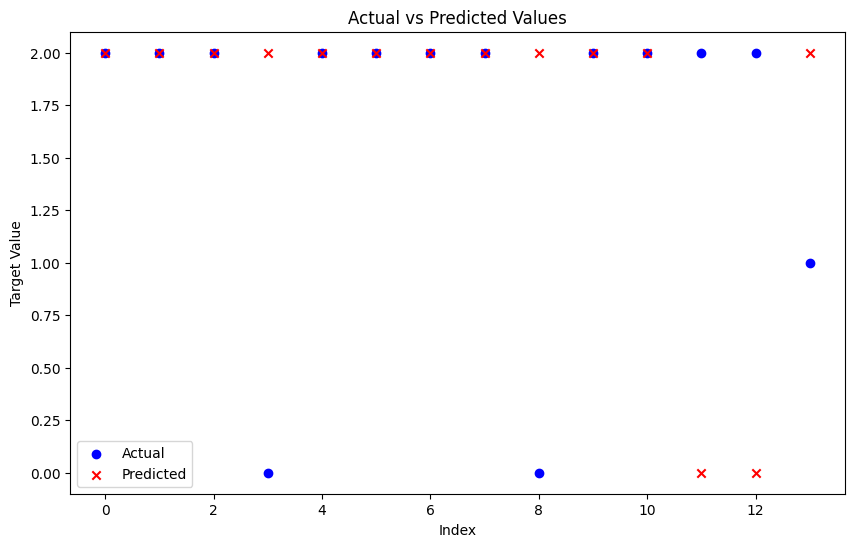

In [103]:
# Assuming you have y_new_actual and y_new_pred lists
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_new_actual)), y_new_actual, label='Actual', color='blue', marker='o')
plt.scatter(range(len(y_new_pred)), y_new_pred, label='Predicted', color='red', marker='x')
plt.xlabel('Index')
plt.ylabel('Target Value')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.show()
